Function: F1
Execution Time: 3.4037728309631348 seconds
Flamingo Search Best Solution: [ 0.65725989 -0.5650934   0.19215947 -0.6652608  -0.23646197  0.317458
  0.38793243 -0.19935031 -0.29563694 -0.34939119  0.23605143  0.01752602
 -0.14724274 -0.09301022  0.01289301  0.20900867  0.52332313 -0.64104733
  0.31773651 -0.18666839  0.24551153 -0.52197813  0.05463296 -0.4523605
  0.80526233 -0.89083449  0.63257474 -0.43904262 -0.25779658  0.29516311
  0.50172958  0.26889922  0.57543305  0.20345849  0.15361571  0.33202134
 -0.38354303 -0.08336913 -0.18612811  0.85358406  0.25090773  0.45639704
 -0.05860269  0.21432585  0.47199234  0.53863881 -0.10413309  0.33608665
  0.23919089  1.13787311] Objective Value: 9.523910312361863
Genetic Algorithm Best Solution: [-0.03808276  0.70081018  0.12393344  0.19766154 -0.00728068  0.14046344
  0.02090549  0.16581705  0.18406625 -0.20206905 -0.04463563  0.21060671
 -0.39167536 -0.078874    0.30315962 -0.27452554 -0.12073    -0.34339405
 -0.2047263  -0.508

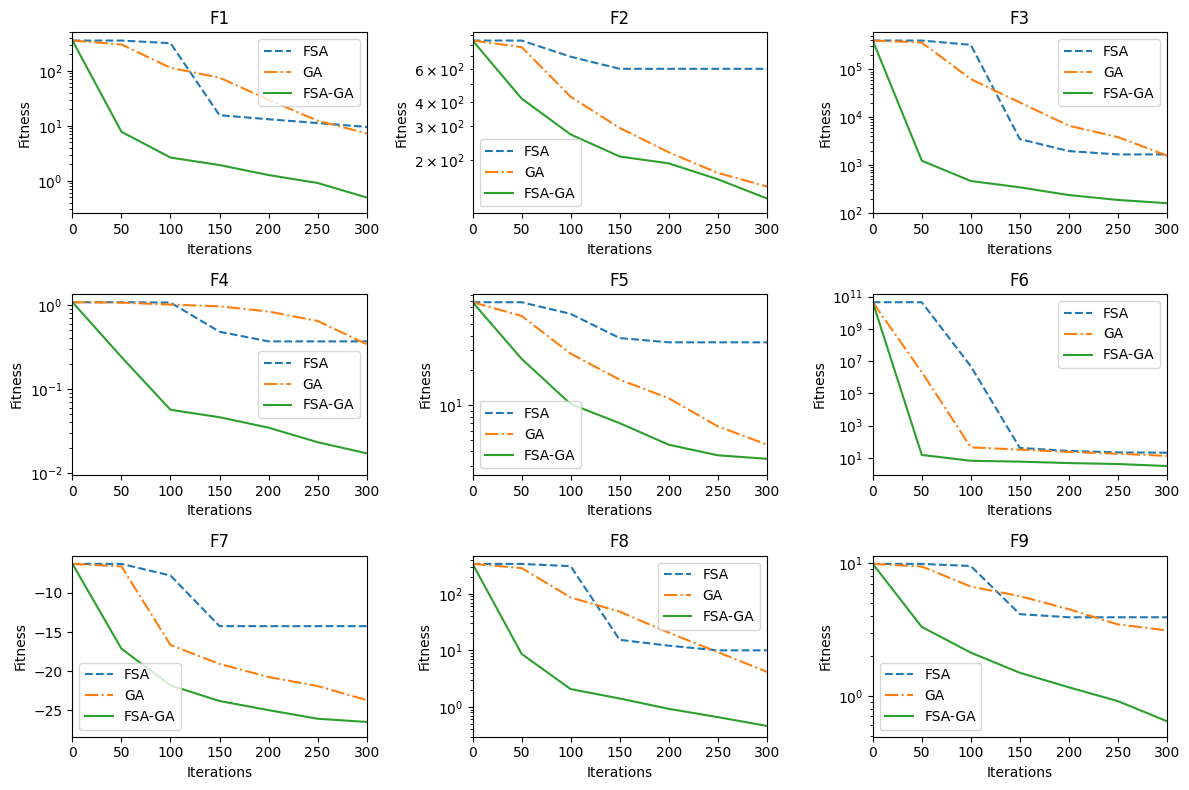

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math

# Objective functions
def F1(x):
    return np.sum(x**2)

def F2(x):
    A = 10
    return A * len(x) + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in x])

def F3(x):
    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

def F4(x):
    return 1/4000 * np.sum(x**2) - np.prod(np.cos(x / np.sqrt(np.arange(1, len(x) + 1)))) + 1

def F5(x):
    return np.sum(np.abs(x * np.sin(x) + 0.1 * x))

def F6(x):
    sum = 0
    sum1 = 1
    for i in range(len(x)):
        sum += np.abs(x[i])
        sum1 *= np.abs(x[i])
    return sum + sum1

def F7(x):
    m = 10
    return -np.sum(np.sin(x) * np.sin(((np.arange(1, len(x) + 1) * x**2) / np.pi)**(2 * m)))

def F8(x):
    sum = 0
    for i in range(len(x)):
        sum += (x[i] + 0.5) * (x[i] + 0.5)
    return sum

def F9(x):
    n = len(x)
    return -20 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / n)) - np.exp(np.sum(np.cos(2 * np.pi * x)) / n) + 20 + np.exp(1)

# Flamingo Search Algorithm
def flamingo_search(objective_function, initial_solution, n_iter, n_flamingos, sigma):
    best_solution = initial_solution
    best_objective_value = objective_function(best_solution)
    convergence = [best_objective_value]

    for i in range(n_iter):
        flamingos = [best_solution + np.random.normal(scale=sigma, size=len(best_solution)) for _ in range(n_flamingos)]
        for f in flamingos:
            f_value = objective_function(f)
            if f_value < best_objective_value:
                best_solution = f
                best_objective_value = f_value
        if i % 50 == 0:
            convergence.append(best_objective_value)

    convergence.append(best_objective_value)  # Final value at iteration 100
    return best_solution, convergence

# Genetic Algorithm Functions
def create_population(size, dim, lb=-5, ub=5):
    return np.random.uniform(lb, ub, (size, dim))

def fitness_function(population, objective_function):
    fitness = np.array([objective_function(ind) for ind in population])
    fitness_prob = 1 / (fitness + 1e-10)  # Inverse of objective value
    fitness_prob -= np.min(fitness_prob)  # Make sure all probabilities are non-negative
    fitness_prob /= np.sum(fitness_prob)  # Normalize to make sum of probabilities equal to 1
    return fitness_prob

def selection(population, fitness, num_parents):
    parents_idx = np.random.choice(len(population), size=num_parents, replace=False, p=fitness)
    return population[parents_idx]

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        crossover_point = np.random.randint(1, offspring_size[1] - 1)
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, mutation_rate=0.1):
    for idx in range(offspring_crossover.shape[0]):
        if np.random.rand() < mutation_rate:
            random_index = np.random.randint(0, offspring_crossover.shape[1])
            offspring_crossover[idx, random_index] += np.random.normal()
    return offspring_crossover

# Function to format results
def format_results(fs_convergence, ga_convergence, fsga_convergence):
    results = []
    for i in [100, 200, 300]:
        fs_fitness = fs_convergence[i // 50]
        ga_fitness = ga_convergence[i // 50]
        fsga_fitness = fsga_convergence[i // 50]
        results.append(f"{i}\t{ga_fitness}\t{fs_fitness}\t{fsga_fitness}")
    return results

def genetic_algorithm(population, objective_function, generations, mutation_rate=0.1, elitism_rate=0.1):
    convergence = []
    best_objective_value = np.inf

    for gen in range(generations):
        fitness = fitness_function(population, objective_function)
        parents = selection(population, fitness, len(population) // 2)
        offspring_crossover = crossover(parents, (len(population) - len(parents), population.shape[1]))
        offspring_mutation = mutation(offspring_crossover, mutation_rate)
        population[len(parents):] = offspring_mutation

        # Elitism: Keep top elitism_rate * 100% individuals
        num_elites = int(elitism_rate * len(population))
        elites = population[np.argsort([objective_function(ind) for ind in population])[:num_elites]]
        population[:num_elites] = elites

        best_solution = population[np.argmin([objective_function(ind) for ind in population])]
        current_best_value = objective_function(best_solution)
        if current_best_value < best_objective_value:
            best_objective_value = current_best_value
        if gen % 50 == 0:
            convergence.append(best_objective_value)

    convergence.append(best_objective_value)  # Final value at iteration 100
    return best_solution, convergence


# Flamingo Search and Genetic Algorithm Combined
def flamingo_genetic_search(objective_function, initial_solution, n_iter, n_flamingos, sigma, generations, population_size):
    # Flamingo Search
    fs_best_solutions = [flamingo_search(objective_function, initial_solution, n_iter, n_flamingos, sigma)[0] for _ in range(10)]
    # Create population from best solutions found by FSA
    population = create_population(population_size, len(initial_solution))
    population[:10] = fs_best_solutions
    # Apply GA on initial population from FSA
    best_solution, convergence = genetic_algorithm(population, objective_function, generations)
    return best_solution, convergence


# Main Loop to Test All Functions
functions = [F1, F2, F3, F4, F5, F6, F7, F8, F9]
function_names = ["F1", "F2", "F3", "F4", "F5", "F6", "F7" , "F8", "F9"]

n_iter = 300  # Number of iterations for FSA
n_flamingos = 100  # Number of Flamingos
sigma = 0.5  # Step size in FSA
generations = 300  # Number of generations for GA
population_size = 100  # Population size for GA
dim = 50  # Dimension of the problem
lb = -5
ub = 5

fig, axs = plt.subplots(3, 3, figsize=(12, 8))
axs = axs.ravel()

for i, (func, func_name) in enumerate(zip(functions, function_names)):
    # Step 0: Initial random solutions and select the best
    initial_population = create_population(10, dim)
    initial_objective_values = np.array([func(ind) for ind in initial_population])
    best_initial_index = np.argmin(initial_objective_values)
    initial_solution = initial_population[best_initial_index]
    initial_value = initial_objective_values[best_initial_index]

    time_start = time.time()

    # Flamingo Search
    fs_best_solution, fs_convergence = flamingo_search(func, initial_solution, n_iter, n_flamingos, sigma)
    fs_convergence.insert(0, initial_value)  # Insert initial value at the beginning

    # Genetic Algorithm
    population = create_population(population_size, dim)
    population[0] = initial_solution  # Ensure starting from the same initial solution
    ga_best_solution, ga_convergence = genetic_algorithm(population, func, generations)
    ga_convergence.insert(0, initial_value)  # Insert initial value at the beginning

    # Flamingo Search and Genetic Algorithm Mixed
    fsga_best_solution, fsga_convergence = flamingo_genetic_search(func, initial_solution, n_iter, n_flamingos, sigma, generations, population_size)
    fsga_convergence.insert(0, initial_value)  # Insert initial value at the beginning

    time_end = time.time()

    # Print Results
    print(f"Function: {func_name}")
    print("Execution Time:", time_end - time_start, "seconds")
    print("Flamingo Search Best Solution:", fs_best_solution, "Objective Value:", func(fs_best_solution))
    print("Genetic Algorithm Best Solution:", ga_best_solution, "Objective Value:", func(ga_best_solution))
    print("Flamingo Search and Genetic Algorithm Mixed Best Solution:", fsga_best_solution, "Objective Value:", func(fsga_best_solution))

    # Format and print results for iterations 100, 200, 300
    formatted_results = format_results(fs_convergence, ga_convergence, fsga_convergence)
    print("Iteration\t100\t200\t300")
    for result in formatted_results:
        print(func_name + "_" + result)
    
    # Plot Convergence Comparison
    x_points = np.arange(0, len(fs_convergence) * 50, 50)  # Adjust x_points to match the interval

    # Check lengths of convergence arrays and adjust if necessary
    convergence_arrays = [fs_convergence, ga_convergence, fsga_convergence]
    min_length = min(map(len, convergence_arrays))
    convergence_arrays = [arr[:min_length] for arr in convergence_arrays]
    x_points = x_points[:min_length]

    axs[i].plot(x_points, convergence_arrays[0], label='FSA', linestyle='--')
    axs[i].plot(x_points, convergence_arrays[1], label='GA', linestyle='-.')
    axs[i].plot(x_points, convergence_arrays[2], label='FSA-GA')
    axs[i].set_title(func_name)
    axs[i].set_xlabel('Iterations')
    axs[i].set_ylabel('Fitness')    
    if func_name != "F7":
        axs[i].set_yscale('log')  
    axs[i].legend()
    axs[i].set_xlim(0, 300)

plt.tight_layout()
plt.show()


Function: F1
Execution Time: 3.7034475803375244 seconds
Flamingo Search Best Solution: [-0.34294419 -0.05049183  0.67581383 -0.06791749 -0.54833246  0.44035694
  0.42161092  0.28255575 -0.76181489 -0.44927449 -0.0399635  -0.22726665
  0.27535228  0.24844323 -0.03679202  0.23006463  0.72648368  0.81659741
 -0.67593655  0.59329881  0.29278256  0.11230522  0.40767167 -0.08484195
 -0.05484184 -0.0237356   0.18655826 -0.20101026  0.31939522 -1.00363359
 -0.01172312 -0.16162506  0.08230118 -0.43223761  0.40167573  0.69380518
  0.0749473  -0.96957524 -0.10515071 -0.46185697  0.19307946  0.18925131
  0.82543864 -0.26726805 -0.50820336  0.14141638 -0.55601164 -1.10396419
  0.12480862 -0.29143628] Objective Value: 10.589440372733991
Genetic Algorithm Best Solution: [-0.11642538  0.10961581 -0.22589942 -0.43009099 -0.19906747 -0.04929541
 -0.12747693 -0.17321868 -0.15461622 -0.19895383  0.01820797  0.12539271
 -0.25037806 -0.21342614 -0.08540469  0.00549917  0.37590613  0.25516174
  0.21327351 -0

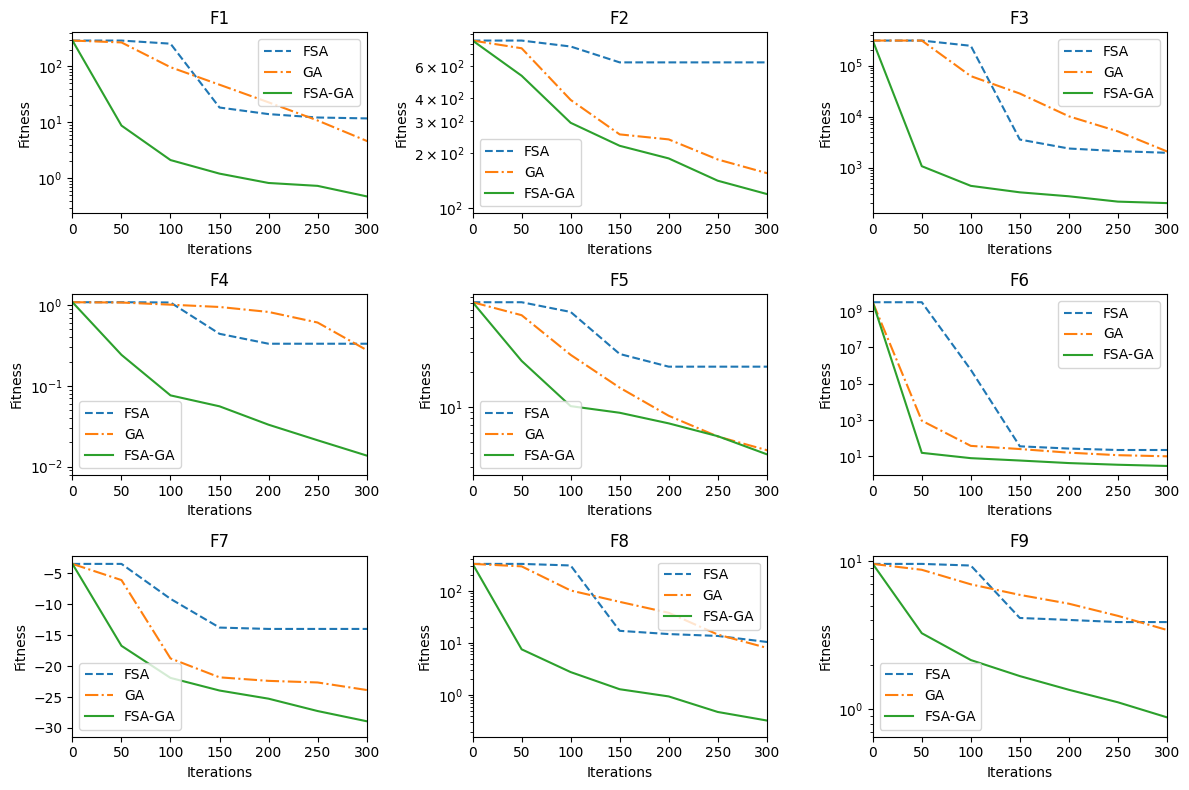

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math

# Objective functions
def F1(x):
    return np.sum(x**2)

def F2(x): #change with other functions

    A = 10  # Modify this constant as needed
    return A * len(x) + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in x])

def F3(x):
    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

def F4(x):
    return 1/4000 * np.sum(x**2) - np.prod(np.cos(x / np.sqrt(np.arange(1, len(x) + 1)))) + 1

def F5(x):  # Alpine Function
    return np.sum(np.abs(x * np.sin(x) + 0.1 * x))


def F6(x):
    sum=0
    sum1=1
    for i in range(len(x)):
        sum+=np.abs(x[i])
        sum1*=np.abs(x[i])
    return sum+sum1

def F7(x):  # Michalewicz Function
    m = 10
    return -np.sum(np.sin(x) * np.sin(((np.arange(1, len(x) + 1) * x**2) / np.pi)**(2 * m)))


def F8(x):
    sum=0
    for i in range(len(x)):
        sum+=(x[i]+0.5)*(x[i]+0.5)
    return sum

def F9(x):
    n = len(x)
    return -20 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / n)) - np.exp(np.sum(np.cos(2 * np.pi * x)) / n) + 20 + np.exp(1)

# Flamingo Search Algorithm
def flamingo_search(objective_function, initial_solution, n_iter, n_flamingos, sigma):
    best_solution = initial_solution
    best_objective_value = objective_function(best_solution)
    convergence = [best_objective_value]

    for i in range(n_iter):
        flamingos = [best_solution + np.random.normal(scale=sigma, size=len(best_solution)) for _ in range(n_flamingos)]
        for f in flamingos:
            f_value = objective_function(f)
            if f_value < best_objective_value:
                best_solution = f
                best_objective_value = f_value
        if i % 50 == 0:
            convergence.append(best_objective_value)

    convergence.append(best_objective_value)  # Final value at iteration 100
    return best_solution, convergence

# Genetic Algorithm Functions
def create_population(size, dim, lb=-5, ub=5):
    return np.random.uniform(lb, ub, (size, dim))

def fitness_function(population, objective_function):
    fitness = np.array([objective_function(ind) for ind in population])
    fitness_prob = 1 / (fitness + 1e-10)  # Inverse of objective value
    fitness_prob -= np.min(fitness_prob)  # Make sure all probabilities are non-negative
    fitness_prob /= np.sum(fitness_prob)  # Normalize to make sum of probabilities equal to 1
    return fitness_prob

def selection(population, fitness, num_parents):
    parents_idx = np.random.choice(len(population), size=num_parents, replace=False, p=fitness)
    return population[parents_idx]

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        crossover_point = np.random.randint(1, offspring_size[1] - 1)
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, mutation_rate=0.1):
    for idx in range(offspring_crossover.shape[0]):
        if np.random.rand() < mutation_rate:
            random_index = np.random.randint(0, offspring_crossover.shape[1])
            offspring_crossover[idx, random_index] += np.random.normal()
    return offspring_crossover

# def genetic_algorithm(population, objective_function, generations, mutation_rate=0.1, elitism_rate=0.1):
#     convergence = []
#     best_objective_value = np.inf

#     for gen in range(generations):
#         fitness = fitness_function(population, objective_function)
#         parents = selection(population, fitness, len(population) // 2)
#         offspring_crossover = crossover(parents, (len(population) - len(parents), population.shape[1]))
#         offspring_mutation = mutation(offspring_crossover, mutation_rate)
#         population[:len(parents)] = parents
#         population[len(parents):] = offspring_mutation

#         # Elitism
#         num_elites = int(elitism_rate * len(population))
#         elites = population[np.argsort([objective_function(ind) for ind in population])[:num_elites]]
#         population[:num_elites] = elites

#         best_solution = population[np.argmin([objective_function(ind) for ind in population])]
#         current_best_value = objective_function(best_solution)
#         if current_best_value < best_objective_value:
#             best_objective_value = current_best_value
#         if gen % 50 == 0:
#             convergence.append(best_objective_value)

#     convergence.append(best_objective_value)  # Final value at iteration 100
#     return best_solution, convergence

# Function to format results
def format_results(fs_convergence, ga_convergence, fsga_convergence):
    results = []
    for i in [100, 200, 300]:
        fs_fitness = fs_convergence[i // 50]
        ga_fitness = ga_convergence[i // 50]
        fsga_fitness = fsga_convergence[i // 50]
        results.append(f"{i}\t{ga_fitness}\t{fs_fitness}\t{fsga_fitness}")
    return results
def genetic_algorithm(population, objective_function, generations, mutation_rate=0.1, elitism_rate=0.1):
    convergence = []
    best_objective_value = np.inf

    for gen in range(generations):
        fitness = fitness_function(population, objective_function)
        parents = selection(population, fitness, len(population) // 2)
        offspring_crossover = crossover(parents, (len(population) - len(parents), population.shape[1]))
        offspring_mutation = mutation(offspring_crossover, mutation_rate)
        population[len(parents):] = offspring_mutation

        # Elitism: Keep top elitism_rate * 100% individuals
        num_elites = int(elitism_rate * len(population))
        elites = population[np.argsort([objective_function(ind) for ind in population])[:num_elites]]
        population[:num_elites] = elites

        best_solution = population[np.argmin([objective_function(ind) for ind in population])]
        current_best_value = objective_function(best_solution)
        if current_best_value < best_objective_value:
            best_objective_value = current_best_value
        if gen % 50 == 0:
            convergence.append(best_objective_value)

    convergence.append(best_objective_value)  # Final value at iteration 100
    return best_solution, convergence


# Flamingo Search and Genetic Algorithm Combined
def flamingo_genetic_search(objective_function, initial_solution, n_iter, n_flamingos, sigma, generations, population_size):
    # Flamingo Search
    fs_best_solutions = [flamingo_search(objective_function, initial_solution, n_iter, n_flamingos, sigma)[0] for _ in range(10)]
    # Create population from best solutions found by FSA
    population = create_population(population_size, len(initial_solution))
    population[:10] = fs_best_solutions
    # Apply GA on initial population from FSA
    best_solution, convergence = genetic_algorithm(population, objective_function, generations)
    return best_solution, convergence
#------------------------------------------------------------------------------------------------------------------------------------------------------
# # Main Loop to Test All Functions
# functions = [F1, F2, F3, F4, F5, F6, F7, F8, F9]
# function_names = ["F1", "F2", "F3", "F4", "F5", "F6", "F7" , "F8", "F9"]

# n_iter = 300  # Number of iterations for FSA
# n_flamingos = 100  # Number of Flamingos
# sigma = 0.5  # Step size in FSA
# generations = 300  # Number of generations for GA
# population_size = 100  # Population size for GA
# dim = 10  # Dimension of the problem
# lb = -5
# ub = 10

# fig, axs = plt.subplots(3, 3, figsize=(12, 8))
# axs = axs.ravel()

# for i, (func, func_name) in enumerate(zip(functions, function_names)):
#     # Step 0: Initial random solutions and select the best
#     initial_population = create_population(10, dim)
#     initial_objective_values = np.array([func(ind) for ind in initial_population])
#     best_initial_index = np.argmin(initial_objective_values)
#     initial_solution = initial_population[best_initial_index]
#     initial_value = initial_objective_values[best_initial_index]

#     time_start = time.time()

#     # Flamingo Search
#     fs_best_solution, fs_convergence = flamingo_search(func, initial_solution, n_iter, n_flamingos, sigma)
#     fs_convergence.insert(0, initial_value)  # Insert initial value at the beginning

#     # Genetic Algorithm
#     population = create_population(population_size, dim)
#     population[0] = initial_solution  # Ensure starting from the same initial solution
#     ga_best_solution, ga_convergence = genetic_algorithm(population, func, generations)
#     ga_convergence.insert(0, initial_value)  # Insert initial value at the beginning

#     # Flamingo Search and Genetic Algorithm Mixed
#     fsga_best_solution, fsga_convergence = flamingo_genetic_search(func, initial_solution, n_iter, n_flamingos, sigma, generations, population_size)
#     fsga_convergence.insert(0, initial_value)  # Insert initial value at the beginning

#     time_end = time.time()

#     # Print Results
#     print(f"Function: {func_name}")
#     print("Execution Time:", time_end - time_start, "seconds")
#     print("Flamingo Search Best Solution:", fs_best_solution, "Objective Value:", func(fs_best_solution))
#     print("Genetic Algorithm Best Solution:", ga_best_solution, "Objective Value:", func(ga_best_solution))
#     print("Flamingo Search and Genetic Algorithm Mixed Best Solution:", fsga_best_solution, "Objective Value:", func(fsga_best_solution))

#     # Format and print results for iterations 100, 200, 300
#     formatted_results = format_results(fs_convergence, ga_convergence, fsga_convergence)
#     print("Interation\t100\t200\t300")
#     for result in formatted_results:
#         print(func_name + "_" + result)
#     # Plot Convergence Comparison
#     x_points = np.arange(0, len(fs_convergence) * 50, 50)  # Adjust x_points to match the interval

#     # Check lengths of convergence arrays and adjust if necessary
#     convergence_arrays = [fs_convergence, ga_convergence, fsga_convergence]
#     min_length = min(map(len, convergence_arrays))
#     convergence_arrays = [arr[:min_length] for arr in convergence_arrays]
#     x_points = x_points[:min_length]

#     axs[i].plot(x_points, convergence_arrays[0], label='FSA', linestyle='--')
#     axs[i].plot(x_points, convergence_arrays[1], label='GA', linestyle='-.')
#     axs[i].plot(x_points, convergence_arrays[2], label='FSA-GA')
#     axs[i].set_title(func_name)
#     axs[i].set_xlabel('Iterations')
#     axs[i].set_ylabel('Fitness')    
#     if func_name != "F7":
#         axs[i].set_yscale('log')  
#     axs[i].legend()
#     axs[i].set_xlim(0, 300)


# plt.tight_layout()
# plt.show()



# Function to format results for Iteration 100, 200, 300
def format_results(fs_convergence, ga_convergence, fsga_convergence):
    results = []
    for i in [100, 200, 300]:
        fs_fitness = fs_convergence[i // 50]
        ga_fitness = ga_convergence[i // 50]
        fsga_fitness = fsga_convergence[i // 50]
        results.append(f"Iteration {i}\tFSA: {fs_fitness:.4e}\tGA: {ga_fitness:.4e}\tFSA-GA: {fsga_fitness:.4e}")
    return results

# Main Loop to Test All Functions
functions = [F1, F2, F3, F4, F5, F6, F7, F8, F9]
function_names = ["F1", "F2", "F3", "F4", "F5", "F6", "F7" , "F8", "F9"]

n_iter = 300  # Number of iterations for FSA
n_flamingos = 100  # Number of Flamingos
sigma = 0.5  # Step size in FSA
generations = 300  # Number of generations for GA
population_size = 100  # Population size for GA
dim = 50  # Dimension of the problem
lb = -5
ub = 5

fig, axs = plt.subplots(3, 3, figsize=(12, 8))
axs = axs.ravel()

for i, (func, func_name) in enumerate(zip(functions, function_names)):
    # Step 0: Initial random solutions and select the best
    initial_population = create_population(10, dim)
    initial_objective_values = np.array([func(ind) for ind in initial_population])
    best_initial_index = np.argmin(initial_objective_values)
    initial_solution = initial_population[best_initial_index]
    initial_value = initial_objective_values[best_initial_index]

    time_start = time.time()

    # Flamingo Search
    fs_best_solution, fs_convergence = flamingo_search(func, initial_solution, n_iter, n_flamingos, sigma)
    fs_convergence.insert(0, initial_value)  # Insert initial value at the beginning

    # Genetic Algorithm
    population = create_population(population_size, dim)
    population[0] = initial_solution  # Ensure starting from the same initial solution
    ga_best_solution, ga_convergence = genetic_algorithm(population, func, generations)
    ga_convergence.insert(0, initial_value)  # Insert initial value at the beginning

    # Flamingo Search and Genetic Algorithm Mixed
    fsga_best_solution, fsga_convergence = flamingo_genetic_search(func, initial_solution, n_iter, n_flamingos, sigma, generations, population_size)
    fsga_convergence.insert(0, initial_value)  # Insert initial value at the beginning

    time_end = time.time()

    # Print Results
    print(f"Function: {func_name}")
    print("Execution Time:", time_end - time_start, "seconds")
    print("Flamingo Search Best Solution:", fs_best_solution, "Objective Value:", func(fs_best_solution))
    print("Genetic Algorithm Best Solution:", ga_best_solution, "Objective Value:", func(ga_best_solution))
    print("Flamingo Search and Genetic Algorithm Mixed Best Solution:", fsga_best_solution, "Objective Value:", func(fsga_best_solution))

    # Format and print results for iterations 100, 200, 300
    formatted_results = format_results(fs_convergence, ga_convergence, fsga_convergence)
    print("Iteration\t\tFSA\t\tGA\t\tFSA-GA")
    for result in formatted_results:
        print(result)  # Printing the detailed iteration results

    # Plot Convergence Comparison
    x_points = np.arange(0, len(fs_convergence) * 50, 50)  # Adjust x_points to match the interval

    # Check lengths of convergence arrays and adjust if necessary
    convergence_arrays = [fs_convergence, ga_convergence, fsga_convergence]
    min_length = min(map(len, convergence_arrays))
    convergence_arrays = [arr[:min_length] for arr in convergence_arrays]
    x_points = x_points[:min_length]

    axs[i].plot(x_points, convergence_arrays[0], label='FSA', linestyle='--')
    axs[i].plot(x_points, convergence_arrays[1], label='GA', linestyle='-.')
    axs[i].plot(x_points, convergence_arrays[2], label='FSA-GA')
    axs[i].set_title(func_name)
    axs[i].set_xlabel('Iterations')
    axs[i].set_ylabel('Fitness')    
    if func_name != "F7":
        axs[i].set_yscale('log')  
    axs[i].legend()
    axs[i].set_xlim(0, 300)

plt.tight_layout()
plt.show()
